In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['ggplot', 'assets/class.mplstyle'])

red = '#E24A33'
blue = '#348ABD'
purple = '#988ED5'
gray = '#777777'
yellow = '#FBC15E'
green = '#8EBA42'
pink = '#FFB5B8'

---
<div style="text-align: right"><b>Mon 08-12-2019</b></div>

# Bayesian Linear Regression

Based on [Hogg, Bovy, and Lang (2010)](http://adsabs.harvard.edu/abs/2010arXiv1008.4686H).

See also: [lecture](https://www.youtube.com/watch?v=0tYaMTK-1K0&list=PLBB44462E5201DD1E)

The general problem to explore is that of fitting a line to data. We will use it here to explore Bayesian estimates of the parameters of the fit and will dedicate a future class to the more general topic of Linear Regression.

## Problem specification:

We want to determine what is the best line that *fits* the following data:

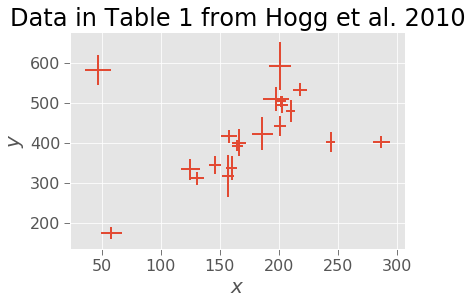

In [2]:
import pandas as pd

data = pd.read_csv('assets/04-table1.csv', index_col='ID')

plt.errorbar(data.x, data.y, yerr=data.sigma_y, xerr=data.sigma_x, ls='None')
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.title('Data in Table 1 from Hogg et al. 2010');

Actually, just knowing the *best* line will not be enough (what does it mean to be the *best line* anyways?), we want to know a probability density function for the parameters of a line that fits the data.

The way to think about it is, in a sense, reversed from the previous statement. We are looking for a line, that represents a model from which the data can be produced. This is the way to think about the problem in general, we want to come up with a model, a **generative model** for the observed data. In particular, the data above seems to have outliers. We need a generative model that generates all the data, including the outliers.

We will start with a simplified problem. We will only worry about the uncertainties in the $y$ direction.

The proposed model is called a Gaussian Mixture. The idea is that there is an intrinsic first order polinomium that explains the origin of most data but there are some points that have a different origin (the outliers). So, we start by assigning to each point a probability that it is an outlier: those are 20 free parameters of the model right away. Then, if the data point is an outlier, we will assume that it was drawn from a very wide gaussian in $y$. We add 2 more parameters to the model for this gaussian. If the model is not an outlier, we will assume that its $y$ positions is a RV that comes from a gaussian distribution centered in the position where the line goes through. With that model in mind, we can write a likelihood for obtaining our observed sample from the data:

$$ \large \mathscr{L} \equiv p(\{y_i\}_{i=1}^N | m, b, \{q_i\}_{i=1}^N, Y_b, V_b)$$

Where the parameters of the model are:

- $m$: the slope of the line
- $b$: the intercept of the line
- $\{q_i\}_{i=1}^N$: one parameter per point that takes a value of $0$ if the point is an outlier, or $1$ if it is not
- $Y_b$: the mean of the gaussian from where the outliers are drawn (the underscore $b$ stands for *bad*)
- $V_b$: the variance of the gaussian from where the outliers are drawn

That's a lot of parameters for the model but since we only really care for $m$ and $b$, we can marginalize the others.

If the data points are all independent then we can write:

$$\Large \mathscr{L} = \prod_{i=1}^N \left[p_{good}(\{y_i\}_{i=1}^N | m, b)\right]^{q_i} \ \left[p_{bad}(\{y_i\}_{i=1}^N|Y_b, V_b)\right]^{1-q_i}$$

$$\Large \mathscr{L} = \prod_{i=1}^N \left[\left(\frac{1}{\sqrt{2\pi}\sigma_{y,i}}\exp\left( -\frac{(y_i - m x_i - b)^2}{2 \sigma^2_{y,i}} \right)\right)\right]^{q_i} \\
\Large \times \left[ \frac{1}{\sqrt{2\pi} [V_b+\sigma^2_{y,i}]} \exp\left( -\frac{(y_i-Y_b)^2}{2(V_b+\sigma^2_{y,i})} \right) \right]^{1-q_i}$$

Now, those $\{q_i\}_{i=1}^N$, represent a sequence of 1's and 0's that is probabilistic. We can model it as a sequence of results drawn from an experiment with two possible outcomes and $N$ total repetitions. That is a Binomial model which has a parameter that we will call $P_b$.

$$ \large p(\{q_i\}_{i=1}^N|Pb) = \prod_{i=1}^N \left( 1-Pb \right)^{q_i} P_b^{1-q_i} $$


With that binomial assumption for the probability of being an outlier we can no define:

$$ \large \mathscr{L} \equiv p(\{y_i\}_{i=1}^N | m, b, P_b, Y_b, V_b)$$

$$\large \mathscr{L} = \prod_{i=1}^N \left[(1-Pb) p_{good}(\{y_i\}_{i=1}^N | m, b) + P_b p_{bad}(\{y_i\}_{i=1}^N|Y_b, V_b)\right]$$


$$\Large \mathscr{L} \propto \prod_{i=1}^N \left[\frac{1-P_b}{\sqrt{2\pi}\sigma_{y,i}}\exp\left( -\frac{(y_i - m x_i - b)^2}{2 \sigma^2_{y,i}} \right) \\
\Large + \frac{P_b}{\sqrt{2\pi} [V_b+\sigma^2_{y,i}]} \exp\left( -\frac{(y_i-Y_b)^2}{2(V_b+\sigma^2_{y,i})} \right) \right]$$


To complete this analysis, this likelihood must be combined with an appropriate prior. Knowing nothing about the points, this prior must represent our lack of knowledge by giving equal probability to all parameters in a wide range.

### One Possible Implementation.

In [3]:
import emcee
print(emcee.__version__)

2.2.1


In [4]:
def ln_prior(theta):
    m, b, Pb, Yb, logVb = theta
    # Vb is a variance, so it should be positive, that's why the logVb
    if -10 < m < 10 and -100 < b < 500 and 0 < Pb < 1 and 0 < Yb < 2000 and -2 < logVb < 10:
        return 0
    return -np.inf

def ln_likelihood(theta, x, y, yerr):
    m, b, Pb, Yb, logVb = theta
    Vb = 10**logVb
    model = m * x + b
    p_fg = (1-Pb) / np.sqrt(2 * np.pi * yerr**2) * np.exp(-(y-model)**2/(2 * yerr**2))
    p_bg = Pb / np.sqrt(2 * np.pi * (Vb + yerr**2)) * np.exp(-(y - Yb)**2/(2 * (Vb + yerr**2)))
    output = np.sum(np.log(p_fg + p_bg))
    return output

def ln_posterior(theta, x, y, yerr):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, x, y, yerr)

In [5]:
np.random.seed(6346)

theta_0 = np.array([1., 200., 0.3, 400, 1.]) # that is (m, b, Pb, Yb, logVb)

ndim, nwalkers = 5, 32
pos_0 = [theta_0 + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                args=(data.x, data.y, data.sigma_y), threads=8)

In [6]:
%timeit -n1 -r1 sampler.run_mcmc(pos_0, 1000);

57.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


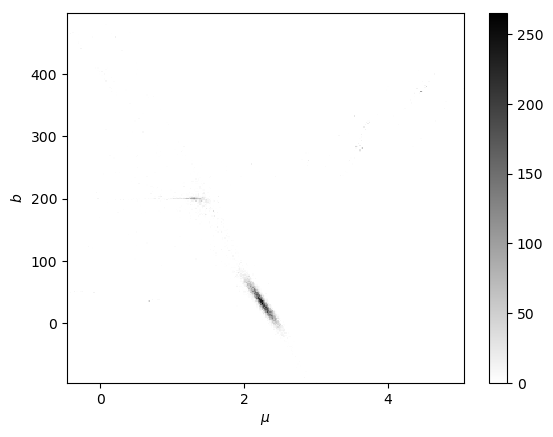

In [7]:
import matplotlib

with plt.style.context('default'):
    plt.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
               cmap='gray_r');
#     plt.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
#                cmap='gray_r', norm=matplotlib.colors.LogNorm());
    plt.xlabel('$\mu$')
    plt.ylabel('$b$')
    plt.colorbar()

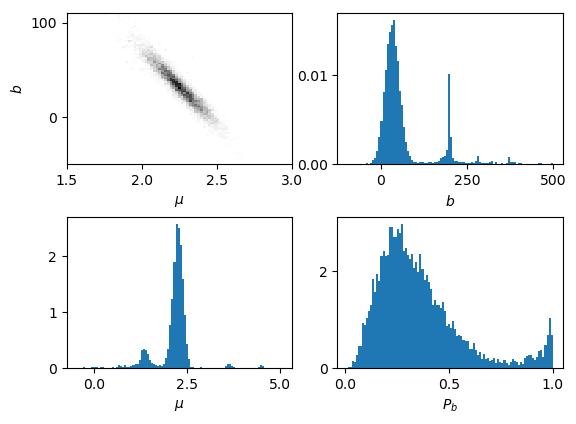

In [8]:
H, xedges, yedges = np.histogram2d(sampler.flatchain[:,0], 
                                   sampler.flatchain[:,1], bins=300)
X, Y = np.meshgrid(xedges, yedges)


with plt.style.context('default'):
    
    plt.subplot(221)
    plt.pcolormesh(X, Y, H.T, cmap='gray_r')
    plt.xlim(1.5, 3)
    plt.ylim(-50, 110)
    plt.xlabel('$\mu$')
    plt.ylabel('$b$')
    
    plt.subplot(222)
    plt.hist(sampler.flatchain[:,1], bins=100, density=True)
    plt.xlabel('$b$')
    
    plt.subplot(223)
    plt.hist(sampler.flatchain[:,0], bins=100, density=True)
    plt.xlabel('$\mu$')

    plt.subplot(224)
    plt.hist(sampler.flatchain[:,2], bins=100, density=True)
    plt.xlabel('$P_b$')
    
    plt.subplots_adjust(top=0.85, hspace=0.35)

Text(0,0.5,'$y$')

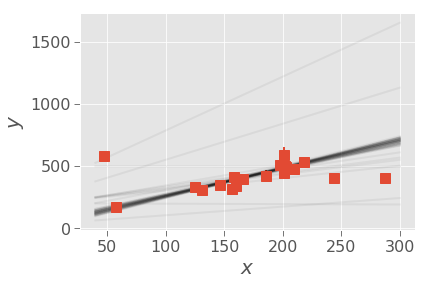

In [9]:
plt.errorbar(data.x, data.y, yerr=data.sigma_y, ls='None', marker='s')

x_to_plot = np.linspace(40, 300, 50)
for i in np.random.randint(0, high=len(sampler.flatchain), size=50):
    m, b = sampler.flatchain[i, [0, 1]]
    plt.plot(x_to_plot, m * x_to_plot + b, color='k', alpha=0.05)


plt.xlabel("$x$")
plt.ylabel("$y$")

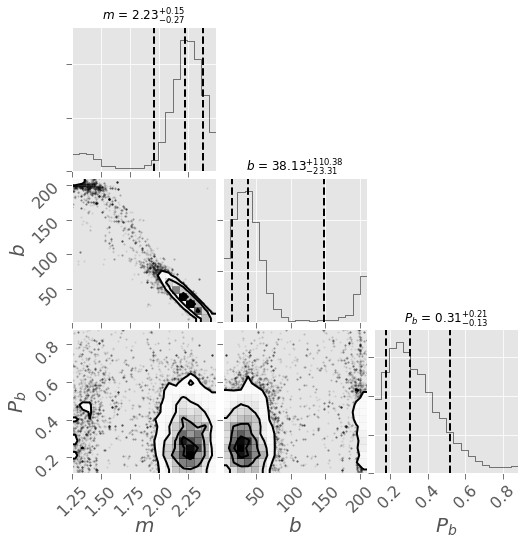

In [10]:
import corner

fig = corner.corner(sampler.flatchain[:,[0, 1, 2]], 
                    labels=["$m$", "$b$", "$P_b$"], 
                    range=(0.9, 0.9, 0.9),
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

Para extensiones considerando barras de error en $x$ a $y$, ver [Hogg et al. (2010)](http://adsabs.harvard.edu/abs/2010arXiv1008.4686H).

